In [1]:
import numpy as np

import math
import pandas as pd
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper')
plt.style.use('seaborn-whitegrid') 


%matplotlib inline

np.random.seed(0)

from math import pi

# generate a 2-D OU process where time-varying parameters are specified as an array
def generateOU(N,dt,mean_p,revert,sigma, X_init=None):
    #This method returns a 2-D OU process using the Euler-Maruyama method
    x = np.zeros((N,2))

    expth = np.exp(-dt*revert)
    stddev = np.sqrt(np.exp(2*dt*revert)-1.0)
    fact = sigma*np.sqrt(1.0-np.exp(-2*dt*revert))/np.sqrt(2*revert)
    for i in range(N-1):

        x[i+1,0]=(x[i,0]*expth[i,0])+(mean_p[i,0]*(1.0-expth[i,0])) + fact[i,0]*np.random.normal(0,1) # revert[i,0]*(mean_p[i,0]-x[i,0])*dt#+math.sqrt(dt)*sigma[i]@np.random.normal(0,1,size=2)
        x[i+1,1]=(x[i,1]*expth[i,1])+(mean_p[i,1]*(1.0-expth[i,1])) + fact[i,1]*np.random.normal(0,1) # revert[i,0]*(mean_p[i,0]-x[i,0])*dt#+math.sqrt(dt)*sigma[i]@np.random.normal(0,1,size=2)

    return x

In [2]:
day_steps=1000
days = 2000
dt=24.0/day_steps
N=int(days*day_steps) # run for 60 days

In [3]:

ls_all = np.load('../data/full_len_sheep_p_0.npy')[:,::1,:]
amps_all = np.load('../data/full_amp_sheep_p_0.npy')[:,::1,:]
# amps = np.mean(amps,axis=0)[:,0]
# ls = np.mean(ls,axis=0)[:,0]
ls_all.shape


(1000, 1000, 1)

In [4]:


sigma=np.zeros((N,2))
revert= np.ones((N,2))

for i in range(days):
    ls = ls_all[i%1000,::1,0]
    amps = amps_all[i%1000,::1,0]
    revert[i*day_steps:(i+1)*day_steps,1]=ls**-1
    revert[i*day_steps:(i+1)*day_steps,0]=ls**-1
    sigma[i*day_steps:(i+1)*day_steps,1]=((amps**2)*(2/ls))**0.5
    sigma[i*day_steps:(i+1)*day_steps,0]=((amps**2)*(2/ls))**0.5

T = 24*np.arange(N)/day_steps

mean_p = np.zeros((N,2))
X=generateOU(N,dt,mean_p,revert,sigma)

positions = dt*np.cumsum(X,axis=0)


/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


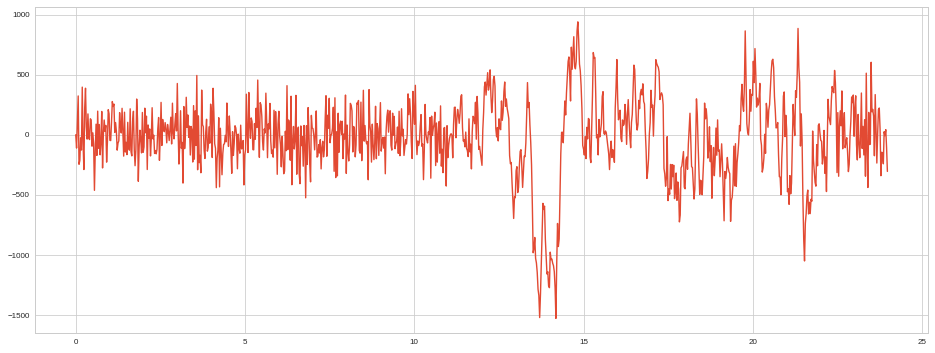

In [230]:
plt.figure(figsize=(16,6))
plt.plot(T[:1000],X[:1000,0])
plt.show()

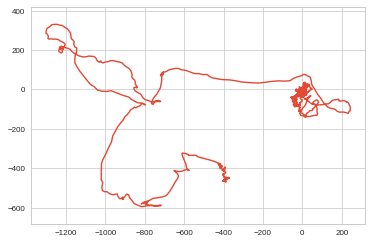

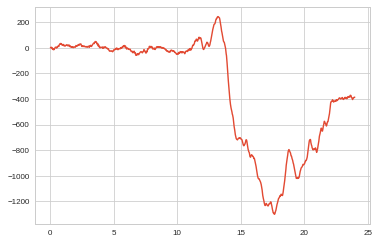

In [73]:
plt.plot(positions[:1000,0],positions[:1000,1])
plt.axis('equal')
plt.show()
plt.plot(T[:1000],positions[:1000,0])
plt.show()

In [5]:
def calculate_steps(T_list,X_list,dt):
    
    steps = []
    turns = []
    
    for X,T in zip(X_list,T_list):
        indexes = np.diff(np.floor(T/dt),prepend=-1)
        Xd = X[indexes>0]
        Xd = np.diff(Xd,axis=0)
        steps.append(np.linalg.norm(Xd,axis=1))
        angles = np.arctan2(Xd[:,1],Xd[:,0])
        angles = np.diff(angles)
        angles[angles>pi]= angles[angles>pi]-pi
        angles[angles<-pi]= angles[angles<-pi]+pi
        turns.append(angles)
    return steps, turns

In [6]:
stepsq, turnsq = calculate_steps([T],[positions],0.25)
steps2, turns2 = calculate_steps([T],[positions],0.5)
steps4, turns4 = calculate_steps([T],[positions],1)

In [7]:
df = pd.read_csv('../data/ovejas.csv')

df['ID'] = df['id'].astype('category').cat.rename_categories(range(0, df['id'].nunique())).astype('int')
ID = df['ID'].values 

Xgps = df[['lat','lon']].values
minX = np.min(Xgps[:,0])
minY = np.min(Xgps[:,1])  
Xmetres = [geodesic((xloc,minY), (minX,minY)).meters for xloc in Xgps[:,0]]
Ymetres = [geodesic((minX,yloc), (minX,minY)).meters for yloc in Xgps[:,1]]


In [8]:

X_emp = np.array([Xmetres, Ymetres]).T
secs =(pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.days.astype(float).values
T_emp = (days*24*60+secs/60)/(60) #hours
#T_emp = T_emp-np.min(T_emp)

XL_emp = []
TL_emp = []

for j in np.unique(ID):
    print('processing ' + str(j))
    
    XX = X_emp[ID==j].copy()
    TT = T_emp[ID==j].copy()
    
    XL_emp.append(XX[::1])
    TL_emp.append(TT[::1])

/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/home/staff1/ctorney/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27


In [9]:
true_steps, true_turns = calculate_steps(TL_emp,XL_emp,0.5)
all_true_steps2 = np.concatenate( true_steps, axis=0 )
all_true_turns2 = np.concatenate( true_turns, axis=0 )

true_steps, true_turns = calculate_steps(TL_emp,XL_emp,1)
all_true_steps4 = np.concatenate( true_steps, axis=0 )
all_true_turns4 = np.concatenate( true_turns, axis=0 )

true_steps, true_turns = calculate_steps(TL_emp,XL_emp,0.25)
all_true_stepsq = np.concatenate( true_steps, axis=0 )
all_true_turnsq = np.concatenate( true_turns, axis=0 )


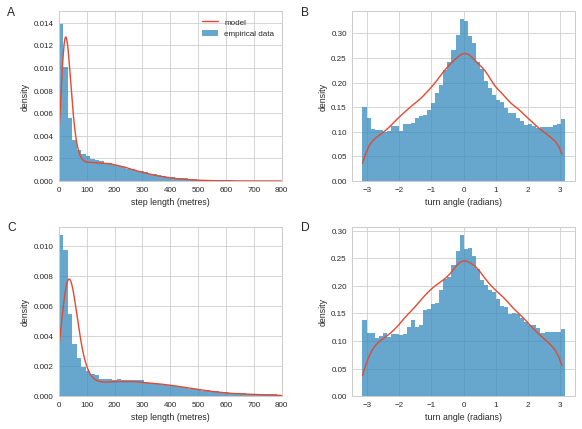

In [12]:
from scipy import stats

gridsize = (2, 2)
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))

density = stats.kde.gaussian_kde(steps2[0])
x = np.arange(0,800, 1)
ax1.plot(x, density(x),label='model')

ax1.hist(all_true_steps2,bins=50,range=[0,800],density=True,alpha=0.75,label='empirical data')
ax1.set_xlim(0,800)
#ax1.set_ylim(0,0.01000)
#plt.show()
#ax1.hist(steps2[0],bins=100,range=[0,2000],density=True,histtype='step')

ax1.set_ylim(0,0.015000)
ax1.legend()
ax1.set_xlabel('step length (metres)')
#ax2.set_yticklabels([])
ax1.set_ylabel('density')
density = stats.kde.gaussian_kde(turns2[0])
x = np.arange(-pi, pi, .1)
ax2.plot(x, density(x))

ax2.hist(all_true_turns2,bins=50,range=[-pi,pi],density=True,alpha=0.75)
#plt.xlim(0,1000)
#plt.ylim(0,0.01000)
#plt.show()
#ax2.hist(turns2[0],bins=50,range=[-pi,pi],density=True,histtype='step')
ax2.set_xlabel('turn angle (radians)')
ax2.set_ylabel('density')

density = stats.kde.gaussian_kde(steps4[0])
x = np.arange(0,800, 1)
ax3.plot(x, density(x))

ax3.hist(all_true_steps4,bins=50,range=[0,800],density=True,alpha=0.75)
ax3.set_xlim(0,800)
#ax3.set_ylim(0,0.01000)
#plt.show()
#ax3.hist(steps4[0],bins=100,range=[0,2000],density=True,histtype='step')
ax3.set_ylabel('density')
ax3.set_xlabel('step length (metres)')
#ax2.set_yticklabels([])


#plt.xlim(0,1000)
#plt.ylim(0,0.01000)
#plt.show()



density = stats.kde.gaussian_kde(turns4[0])
x = np.arange(-pi, pi, .1)
ax4.plot(x, density(x))


#ax4.hist(turns4[0],bins=50,range=[-pi,pi],density=True,alpha=0.5,color='b')
ax4.hist(all_true_turns4,bins=50,range=[-pi,pi],density=True,alpha=0.75)
#ax4.hist(turns4[0],bins=50,range=[-pi,pi],density=True,histtype='step',color='k',linewidth=1)
ax4.set_xlabel('turn angle (radians)')

ax4.set_ylabel('density')

plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .09, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .09, yp- .01, 'B', size=12)

xp = ax3.get_position().x0
yp = ax3.get_position().y1    
fig.text(xp - .09, yp- .01, 'C', size=12)

xp = ax4.get_position().x0
yp = ax4.get_position().y1    
fig.text(xp - .09, yp- .01, 'D', size=12)


plt.savefig('../figures/si_ppc_steps.png', dpi=300, bbox_inches = "tight")


## Speeds

In [13]:
def calculate_speeds(T_list,X_list,dt):
    
    allsimspeeds = []
    turns = []
    
    for X,T in zip(X_list,T_list):
        indexes = np.diff(np.floor(T/dt),prepend=-1)
        Xd = X[indexes>0]
        Td = T[indexes>0]
        Xd = np.diff(Xd,axis=0)
        distance = np.linalg.norm(Xd,axis=1)/1000
        speeds = distance/(np.diff(Td))

        allsimspeeds.append(speeds)
        
    return allsimspeeds


In [14]:
all_sim_speeds = calculate_speeds([T],[positions],1/6)
all_speeds = calculate_speeds(TL_emp,XL_emp,1/6)
all_speeds = np.concatenate( all_speeds, axis=0 )


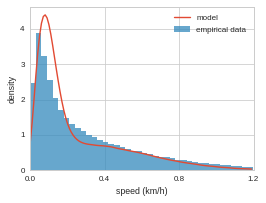

In [15]:
from scipy import stats
#gridsize = (2, 2)
fig = plt.figure(figsize=(4, 3))

#all_sim_speeds = np.linalg.norm(X,axis=1)/1000

#all_sim_speeds=all_sim_speeds[all_sim_speeds<2.5]
density = stats.kde.gaussian_kde(all_sim_speeds)
x = np.arange(0, 1.2,.01)
plt.plot(x, density(x),label='model')
#plt.hist(all_sim_speeds,range=(-1.2,1.2),bins=50,density=True,alpha=0.75,label='empirical data')

#plt.hist(all_sim_speeds,range=(0,1),bins=100,density=True,alpha=0.5)
plt.hist(all_speeds,range=(0,1.20),bins=40,density=True,alpha=0.75,label='empirical data')
plt.xlim(0,1.2)
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::2])
plt.legend()

# xp = ax.get_position().x0
# yp = ax.get_position().y1    
# fig.text(xp - .09, yp- .01, 'D', size=12)
plt.ylabel('density')
plt.xlabel('speed (km/h)')
plt.savefig('../figures/si_speeds.png', dpi=300, bbox_inches = "tight")


In [122]:
TT = T
XX = X
dtt = 1
indexes = np.diff(np.floor(TT/dtt),prepend=-1)
Xd = X[indexes>0]
Xd = np.diff(Xd,axis=0)
steps = np.linalg.norm(Xd,axis=1)


In [128]:


skip=3
#X_emp_vel = df[['velx','vely']].values
#all_speeds = np.linalg.norm(X_emp_vel,axis=1)
all_speeds=np.zeros((0,1))
all_speeds_x=np.zeros((0,1))
all_speeds_y=np.zeros((0,1))
for i in range(len(XL_emp)):
    distance = np.linalg.norm(np.diff(XL_emp[i][::skip],axis=0),axis=1)
    distance_x = np.diff(XL_emp[i][::skip,0],axis=0)
    distance_y = np.diff(XL_emp[i][::skip,1],axis=0)
    speeds = distance/(np.diff(TL_emp[i][::skip]))
    speeds_x = distance_x/(np.diff(TL_emp[i][::skip]))
    speeds_y = distance_y/(np.diff(TL_emp[i][::skip]))
    speeds_x = speeds_x/1000
    speeds_y = speeds_y/1000
    all_speeds= np.vstack((all_speeds,speeds[:,None]/1000))
    all_speeds_x= np.vstack((all_speeds_x,speeds_x[:,None]))
    all_speeds_y= np.vstack((all_speeds_y,speeds_y[:,None]))
    #TL_emp.append(TT)
#all_speeds = np.ravel(np.asarray(all_speeds))

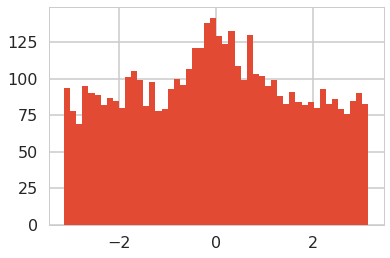

In [131]:
plt.hist(angles,bins=50)
plt.show()